In [1]:
import os

# Change to the parent directory
os.chdir('../..')

# Verify the path using getcwd()
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1


## Building a NARX Neural Network

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from src.file_loader import load_csv_files
# import matplotlib as mpl
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

In [3]:
# Verify the path using getcwd()
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1


In [4]:
# List of file names
file_names = [
    '9171_20241001_N11507060127_ Rapid polarization-2.csv'
    ]

# print(f"Processing file: {file_names}")
dataframes = load_csv_files(file_names, '', 'deep learning assignment')


In [5]:
# Extract the DataFrame
data = dataframes['9171_20241001_N11507060127__Rapid_polarization-2_csv']

# Confirm it's a DataFrame
print(type(data))  # Should output <class 'pandas.core.frame.DataFrame'>

# Use the describe() method
print(data.describe())


<class 'pandas.core.frame.DataFrame'>
       Time (HH:mm:ss.SSS) Channel     CH      V      A
count                16383   16341  16320  16320  16320
unique               16323   16321      2    142     16
top                   Step     CH1    CH1  2.926  2.251
freq                    21      21  16299   2120   5620


In [6]:
data.head()

,Time (HH:mm:ss.SSS),Channel,CH,V,A
0,11:45:54.513,0.780562,CH1,1.429,0.046
1,11:45:54.753,1.0206133,CH1,1.444,0.046
2,11:45:54.983,1.2505946,CH1,1.452,0.046
3,11:45:55.223,1.490689,CH1,1.457,0.046
4,11:45:55.453,1.7206743,CH1,1.461,0.046


In [7]:
data.dtypes

Time (HH:mm:ss.SSS)    object
Channel                object
CH                     object
V                      object
A                      object
dtype: object

In [8]:
# Convert `V` and `A` columns to numeric
data['V'] = pd.to_numeric(data['V'], errors='coerce')
data['A'] = pd.to_numeric(data['A'], errors='coerce')

In [9]:
# Drop rows with NaN values in these columns if conversion fails
data = data.dropna(subset=['V', 'A'])

### Using Feedforward neural network (FNN) Implementation

In [10]:
# Select numeric columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
numeric_data = data[numeric_cols]

# Apply MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(numeric_data)

# Create a new DataFrame with scaled values
scaled_data = pd.DataFrame(scaled, columns=numeric_cols, index=data.index)

# Optional: Combine with non-numeric columns
non_numeric_cols = data.select_dtypes(exclude=['float64', 'int64'])
final_data = pd.concat([non_numeric_cols, scaled_data], axis=1)

# Check the result
print(final_data.head())


  Time (HH:mm:ss.SSS)    Channel   CH         V    A
0        11:45:54.513   0.780562  CH1  0.000000  0.0
1        11:45:54.753  1.0206133  CH1  0.007637  0.0
2        11:45:54.983  1.2505946  CH1  0.011711  0.0
3        11:45:55.223   1.490689  CH1  0.014257  0.0
4        11:45:55.453  1.7206743  CH1  0.016293  0.0


In [11]:
scaled_data.head()

,V,A
0,0.000000,0.0
1,0.007637,0.0
2,0.011711,0.0
3,0.014257,0.0
4,0.016293,0.0


In [12]:
final_data.head()

,Time (HH:mm:ss.SSS),Channel,CH,V,A
0,11:45:54.513,0.780562,CH1,0.000000,0.0
1,11:45:54.753,1.0206133,CH1,0.007637,0.0
2,11:45:54.983,1.2505946,CH1,0.011711,0.0
3,11:45:55.223,1.490689,CH1,0.014257,0.0
4,11:45:55.453,1.7206743,CH1,0.016293,0.0


In [13]:
def create_sequences(input_data, target_column, sequence_length=1, flatten=False):
    inputs = []
    targets = []
    data_size = len(input_data)
    
    for i in range(data_size-sequence_length):
        sequence = input_data[i:i+sequence_length]
        #print(type(sequence))
        label_position = i + sequence_length
        label = input_data[label_position][target_column]
        if flatten:
            inputs.append(sequence.flatten())
        else:
            inputs.append(sequence)
        targets.append(label)
        
    return np.array(inputs), np.array(targets)

In [14]:
x, y = create_sequences(scaled_data.to_numpy(), 1, 3, flatten=True)
x.shape, y.shape

((16296, 6), (16296,))

In [15]:
split_ratio = 0.25
split = int(len(x) * split_ratio)

x_train, x_valid = x[:-split], x[-split:]
y_train, y_valid = y[:-split], y[-split:]

In [16]:


# Assuming x.shape[1] is the number of input features
narxffn_model = keras.Sequential([
    layers.Dense(10, activation='tanh', input_shape=(x.shape[1],)),
    layers.Dense(1, activation='relu')
])

# Corrected: Wrap the metrics argument in a list
narxffn_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='mse',
    metrics=['mae']  # Wrap 'mae' in a list
)

# Adding an EarlyStopping callback
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)


c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\env_analysis\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
history = narxffn_model.fit(x,y, epochs=100, validation_split=0.2, verbose=1, callbacks=[callback])

Epoch 1/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1676 - mae: 0.3326 - val_loss: 0.0871 - val_mae: 0.2689
Epoch 2/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1692 - mae: 0.3359 - val_loss: 0.0871 - val_mae: 0.2689
Epoch 3/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1661 - mae: 0.3315 - val_loss: 0.0871 - val_mae: 0.2689
Epoch 4/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1685 - mae: 0.3344 - val_loss: 0.0871 - val_mae: 0.2689
Epoch 5/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1679 - mae: 0.3334 - val_loss: 0.0871 - val_mae: 0.2689
Epoch 6/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1700 - mae: 0.3373 - val_loss: 0.0871 - val_mae: 0.2689
Epoch 7/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1664 - mae: 0.3306 - val_loss: 0.0871 - val_mae: 0.2689
Epoch 8/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1686 - mae: 0.3347 - val_loss: 0.0871 - val_mae: 0.2689
Epoch 9/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

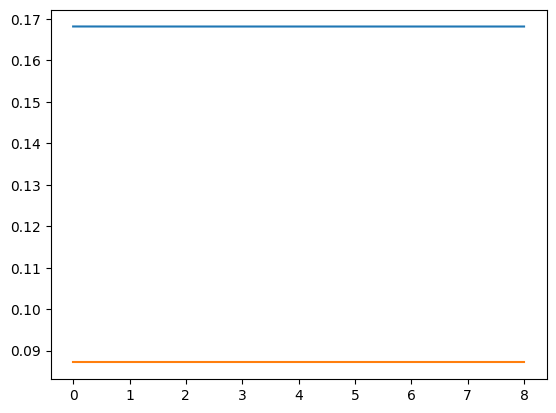

In [18]:
history.history['loss']

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [19]:
history.history['loss']

[0.16817918419837952,
 0.16817031800746918,
 0.1681697815656662,
 0.16816972196102142,
 0.16816973686218262,
 0.16816967725753784,
 0.1681698113679886,
 0.168169766664505,
 0.1681700348854065]

In [20]:
predicted = narxffn_model(x)

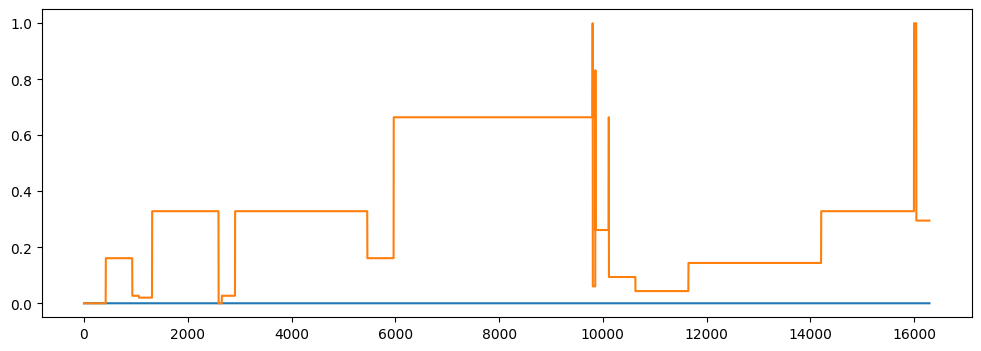

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(predicted)
plt.plot(y)

In [22]:
narxffn_model.evaluate(x,y)

510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1253 - mae: 0.2791


[0.1519591212272644, 0.3210548162460327]

### Classical NARXNN Implementation

In [23]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['V', 'A']])
scaled_df = pd.DataFrame(scaled_data, columns=['V', 'A'])

In [24]:
# Create sequences for NARXNN
def create_narx_sequences(data, target_column, input_lags=3, output_lags=1):
    """Generates sequences with explicit AR and exogenous inputs."""
    inputs, targets = [], []
    n_samples = len(data)

    for i in range(input_lags, n_samples - output_lags):
        # AR terms (past values of the target)
        ar_terms = data[i - input_lags:i, target_column]
        
        # Exogenous terms (past values of the other input variables)
        exog_terms = data[i - input_lags:i, :]
        
        # Concatenate AR terms and exogenous terms
        # inputs.append(np.hstack([ar_terms, exog_terms.flatten()]))
        combined = np.hstack([ar_terms.reshape(-1, 1), exog_terms])
        inputs.append(combined)  # Keep shape as (input_lags, features)
        
        # Future target values for output lags
        targets.append(data[i:i + output_lags, target_column])
    
    return np.array(inputs), np.array(targets)

In [25]:
# Define target (e.g., 'V' column as the target variable)
target_column = 0  # 'V' is the first column
input_lags = 3  # Number of past steps to include
output_lags = 1  # Predict one step ahead

x, y = create_narx_sequences(scaled_data, target_column, input_lags, output_lags)

In [26]:
# Train-test split
split_ratio = 0.25
split = int(len(x) * (1 - split_ratio))
x_train, x_valid = x[:split], x[split:]
y_train, y_valid = y[:split], y[split:]

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

x_train shape: (12221, 3, 3), y_train shape: (12221, 1)


In [27]:
# Check shapes after fixing
print(f"x_train shape: {x_train.shape}")  # Expected: (samples, timesteps, features)
print(f"y_train shape: {y_train.shape}")  # Expected: (samples, output_lags)

x_train shape: (12221, 3, 3)
y_train shape: (12221, 1)


In [28]:
# Define the NARXNN model
narx_model = keras.Sequential([
    layers.LSTM(32, activation='tanh', input_shape=(x_train.shape[1], x_train.shape[2])),
    layers.Dense(16, activation='tanh'),
    layers.Dense(y_train.shape[1], activation='relu')  # Output layer
])

# Compile the model
narx_model.compile(optimizer=keras.optimizers.Adam(), loss='mse', metrics=['mae'])

# Train the model
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\env_analysis\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
history = narx_model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_valid, y_valid),
    callbacks=[callback],
    verbose=1
)


Epoch 1/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0102 - mae: 0.0496 - val_loss: 2.4777e-04 - val_mae: 0.0053
Epoch 2/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.3121e-04 - mae: 0.0053 - val_loss: 2.2092e-04 - val_mae: 0.0024
Epoch 3/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.0637e-04 - mae: 0.0042 - val_loss: 2.1633e-04 - val_mae: 0.0021
Epoch 4/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.0697e-04 - mae: 0.0041 - val_loss: 2.1456e-04 - val_mae: 0.0028
Epoch 5/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6593e-04 - mae: 0.0028 - val_loss: 2.2771e-04 - val_mae: 0.0055
Epoch 6/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.4203e-04 - mae: 0.0043 - val_loss: 2.9316e-04 - val_mae: 0.0105
Epoch 7/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.5339e-04 - mae: 0.0064 - val_loss: 2.9321e-04 - val_mae: 0.0105
Epoch 8/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.1753e-04 - mae: 0.0044 - val_loss: 3.6605e-04 - val_

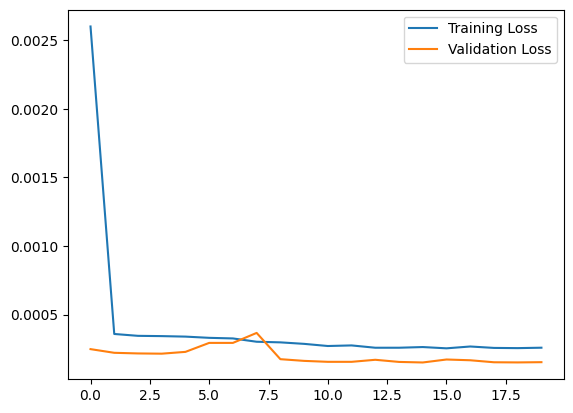

In [30]:

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [31]:
# Make predictions
y_pred = narx_model.predict(x_valid)

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


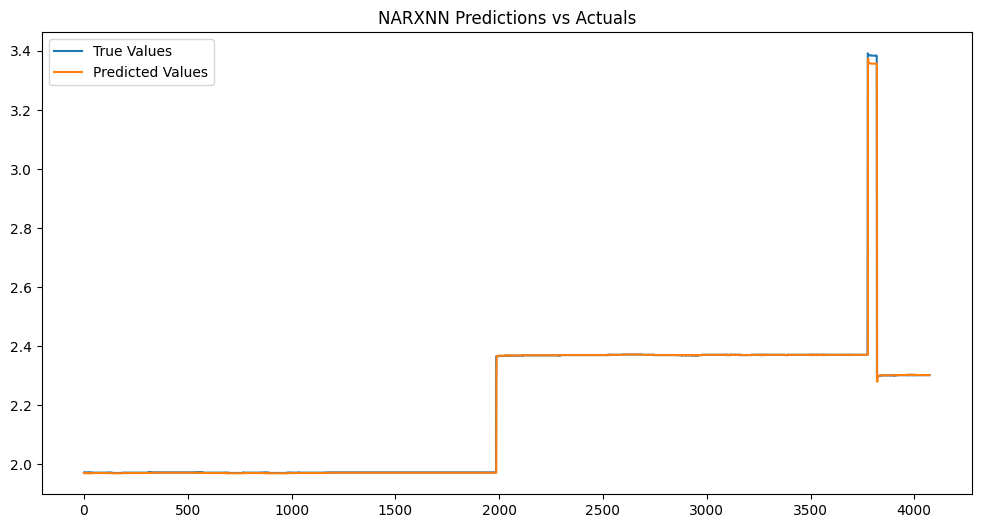

In [32]:
# Rescale back to original values for comparison
y_valid_rescaled = scaler.inverse_transform(np.hstack((y_valid, np.zeros_like(y_valid))))
y_pred_rescaled = scaler.inverse_transform(np.hstack((y_pred, np.zeros_like(y_pred))))

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(y_valid_rescaled[:, 0], label='True Values')
plt.plot(y_pred_rescaled[:, 0], label='Predicted Values')
plt.legend()
plt.title('NARXNN Predictions vs Actuals')
plt.show()